### Can we look at units where a preferred feature explains some amount of variance in certain conditions?
- Look at when a feature is chosen, correct, and then chosen, incorrect. 
- conditions: time, preferred, time/preferred. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import SESS_SPIKES_PATH, TrialInterval, UNITS_PATH
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
import scipy
import argparse
import copy
import itertools
from tqdm import tqdm
from tqdm.auto import tqdm  # for notebooks
from utils.anova_utils import anova_factors, cal_unit_var

In [3]:
def load_data(sess_name, feat, trial_interval, response, subject="SA", unit_id=None):
    beh = behavioral_utils.get_valid_belief_beh_for_sub_sess(subject, sess_name)
    beh = behavioral_utils.get_chosen_single(feat, beh)
    beh = beh[beh.PreferredChosen]

    beh = beh[(beh.Response == response) & (beh.Choice == feat)]
    beh["FeatPreferred"] = beh["PreferredBelief"].apply(lambda x: "Preferred" if x == feat else "Not Preferred")
    num_pref = len(beh[beh.FeatPreferred == "Preferred"])
    num_not_pref = len(beh[beh.FeatPreferred == "Not Preferred"])

    spikes_path = SESS_SPIKES_PATH.format(
        sub=subject,
        sess_name=sess_name, 
        fr_type="firing_rates",
        pre_interval=trial_interval.pre_interval, 
        event=trial_interval.event, 
        post_interval=trial_interval.post_interval, 
        interval_size=trial_interval.interval_size
    )
    frs = pd.read_pickle(spikes_path)
    frs["PseudoUnitID"] = int(sess_name) * 100 + frs.UnitID.astype(int)
    frs = frs[frs.TimeBins > 1.8]
    if unit_id is not None:
        frs = frs[frs.PseudoUnitID == unit_id]
    df = pd.merge(frs, beh, on="TrialNumber")
    return df, num_pref, num_not_pref

def process_session(row, feat, interval, response):
    data, _, _ = load_data(row.session_name, feat, interval, response)
    df = anova_factors(data, ["TimeBins", "FeatPreferred"])
    unit_vars = df.groupby("PseudoUnitID").apply(lambda x: cal_unit_var(x, ["TimeBins", "FeatPreferred"])).reset_index()
    return unit_vars

In [4]:
FEATS_PATH = "/data/patrick_res/sessions/SA/feats_at_least_3blocks.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
feat = "RIPPLE"
response = "Correct"
feat_sessions = pd.read_pickle(FEATS_PATH)
valid_sess = pd.read_pickle(SESSIONS_PATH)
row = feat_sessions[feat_sessions.feat == feat].iloc[0]
sessions = valid_sess[valid_sess.session_name.isin(row.sessions)]
interval = TrialInterval("FeedbackOnset", 1800, 1500, 100)

### Look at correct responses, chose feature

In [5]:
tqdm.pandas()
all_res = []
for feat in FEATURES:
    row = feat_sessions[feat_sessions.feat == feat].iloc[0]
    sessions = valid_sess[valid_sess.session_name.isin(row.sessions)]
    res = pd.concat(sessions.progress_apply(lambda x: process_session(x, feat, interval, response), axis=1).values)
    res["interaction_frac"] = res.x_FeatPreferred_fracvar + res.x_TimeBinsFeatPreferred_fracvar
    res["feat"] = feat
    all_res.append(res)
all_res = pd.concat(all_res)

  0%|          | 0/22 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: 

  0%|          | 0/22 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/15 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/11 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/19 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: 

  0%|          | 0/19 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/21 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/25 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/17 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: 

  0%|          | 0/19 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/16 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var
/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


  0%|          | 0/13 [00:00<?, ?it/s]

/src/wcst_decode/utils/anova_utils.py:53: RuntimeWarning: invalid value encountered in scalar divide
  var_frac = unit_df[comb_str].var() / total_var
/src/wcst_decode/utils/anova_utils.py:56: RuntimeWarning: invalid value encountered in scalar divide
  row["residual_fracvar"] = unit_df.residual.var() / total_var


In [6]:
all_res

,PseudoUnitID,total_var,x_TimeBins_fracvar,x_FeatPreferred_fracvar,x_TimeBinsFeatPreferred_fracvar,residual_fracvar,sum_fracvar,interaction_frac,feat
0,2018070900,0.585536,0.016690,0.005398,0.008576,0.969336,1.0,0.013974,CIRCLE
1,2018070901,0.715437,0.014598,0.001533,0.015184,0.968684,1.0,0.016718,CIRCLE
2,2018070902,2.345495,0.005049,0.001075,0.004107,0.989770,1.0,0.005182,CIRCLE
3,2018070903,5.806598,0.007016,0.000098,0.002963,0.989922,1.0,0.003061,CIRCLE
4,2018070904,5.204337,0.007970,0.047133,0.002166,0.942731,1.0,0.049299,CIRCLE
...,...,...,...,...,...,...,...,...,...
22,2018081722,5.400288,0.019130,0.001556,0.001966,0.977349,1.0,0.003522,SWIRL
23,2018081723,23.758335,0.046469,0.013525,0.006076,0.933930,1.0,0.019601,SWIRL
24,2018081724,1.344850,0.004674,0.004162,0.010794,0.980370,1.0,0.014956,SWIRL
25,2018081725,0.375621,0.010294,0.000415,0.004086,0.985205,1.0,0.004501,SWIRL


In [7]:
units = all_res.sort_values(by="interaction_frac", ascending=False)[:10]

In [8]:
units

,PseudoUnitID,total_var,x_TimeBins_fracvar,x_FeatPreferred_fracvar,x_TimeBinsFeatPreferred_fracvar,residual_fracvar,sum_fracvar,interaction_frac,feat
7,2018081307,13.385685,0.134233,0.137995,0.035658,0.692114,1.0,0.173653,YELLOW
8,2018081308,33.309782,0.058831,0.136742,0.001510,0.802917,1.0,0.138252,YELLOW
6,2018092606,5.473581,0.013934,0.117436,0.000296,0.868334,1.0,0.117732,TRIANGLE
5,2018091205,15.152367,0.110682,0.101276,0.003143,0.784899,1.0,0.104419,CYAN
7,2018091907,5.884730,0.001591,0.080895,0.004647,0.912867,1.0,0.085542,GREEN
8,2018081308,26.843168,0.110880,0.080172,0.001604,0.807344,1.0,0.081776,TRIANGLE
8,2018062508,9.064389,0.030353,0.065222,0.014252,0.890174,1.0,0.079473,CIRCLE
8,2018101008,68.133032,0.261315,0.072704,0.005288,0.660693,1.0,0.077992,ESCHER
0,2018080200,73.244958,0.082972,0.064368,0.012971,0.839690,1.0,0.077338,MAGENTA
17,2018080317,5.364782,0.008711,0.064311,0.008487,0.918491,1.0,0.072798,STAR


In [9]:
unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))

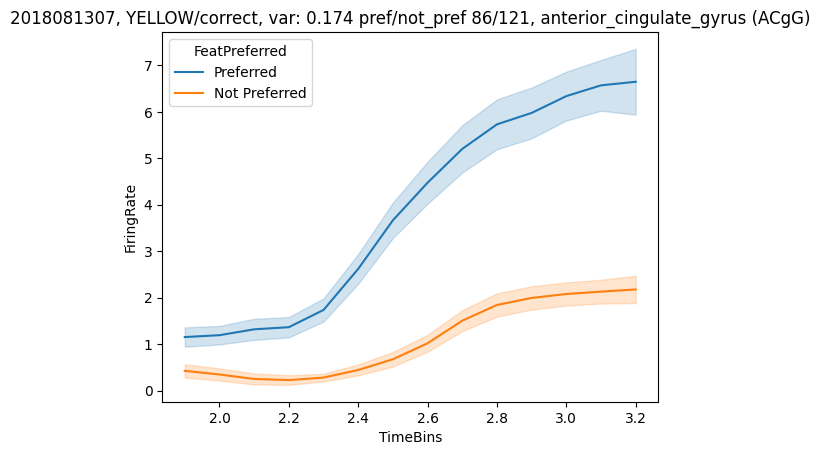

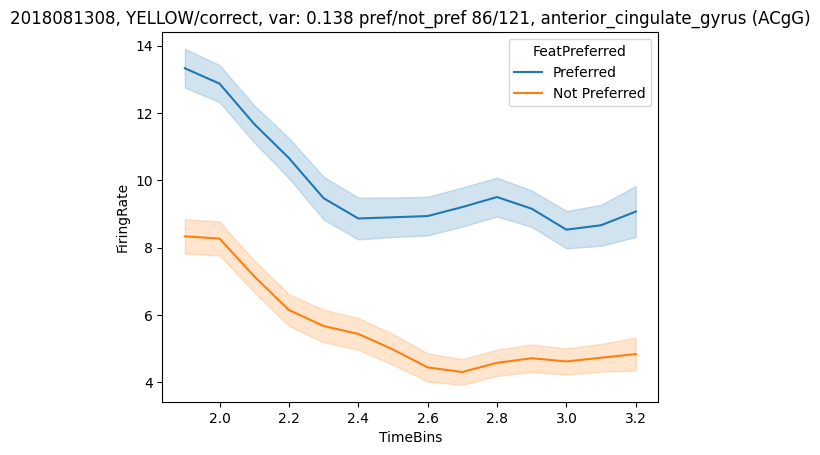

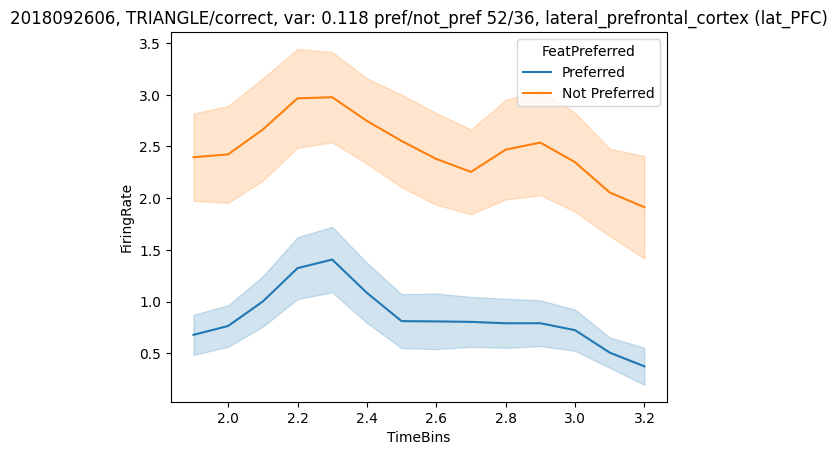

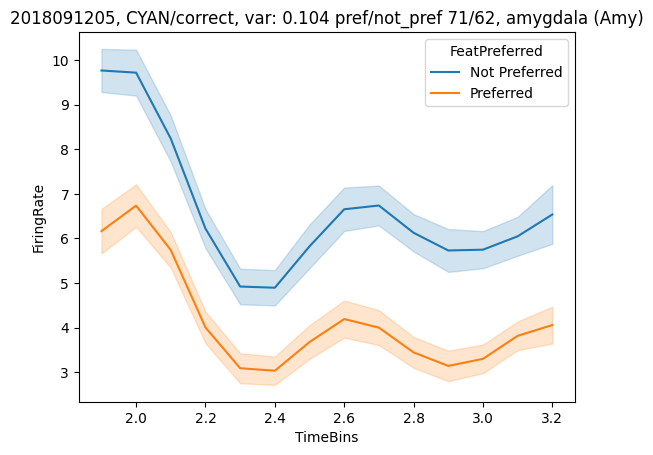

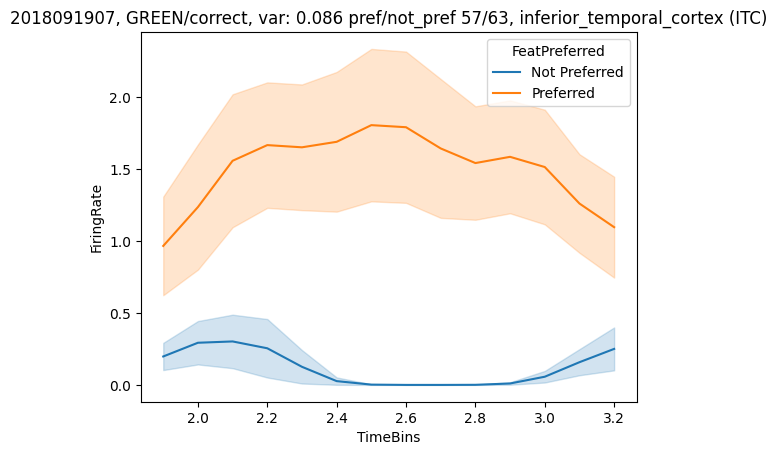

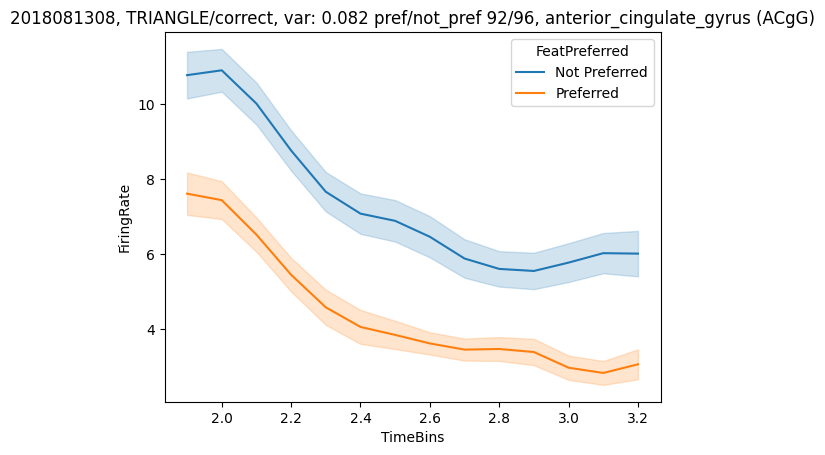

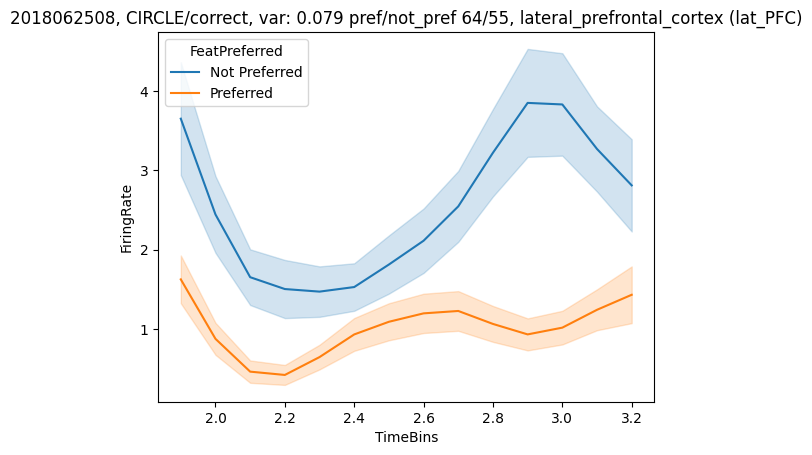

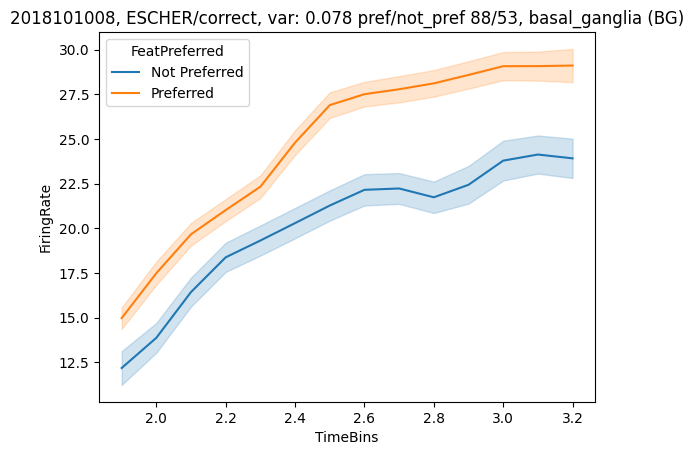

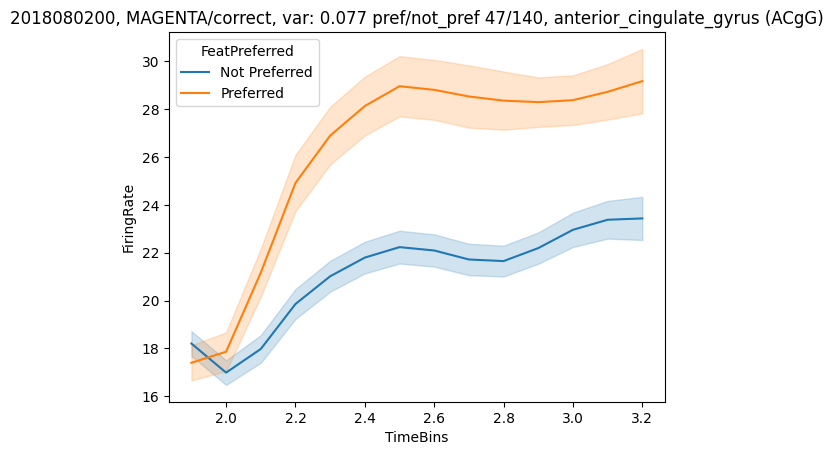

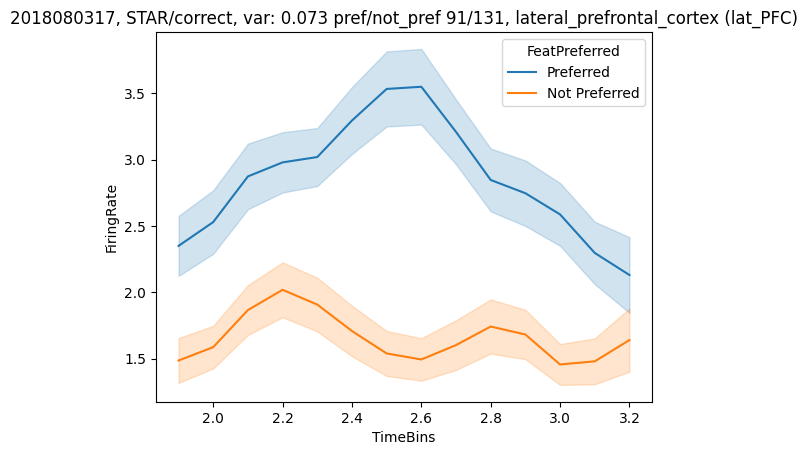

In [10]:
for i, unit in units.iterrows():
    unit_id = int(unit.PseudoUnitID)
    unit_frs, num_pref, num_not_pref = load_data(int(unit_id / 100), unit.feat, interval, response, unit_id=unit_id)
    pos = unit_pos[unit_pos.PseudoUnitID == unit_id].iloc[0].structure_level2

    # unit_frs["FeatPreferred"] = unit_frs["PreferredBelief"].apply(lambda x: x == feat)
    fig, ax = plt.subplots()
    sns.lineplot(unit_frs, x="TimeBins", y="FiringRate", hue="FeatPreferred", errorbar="se", ax=ax)
    ax.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.interaction_frac:.3f} pref/not_pref {num_pref}/{num_not_pref}, {pos}")